In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:14) 
[Clang 12.0.1 ]
Version info.
sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)


In [2]:
from IPython.display import IFrame

IFrame(width="1120", height="630", src="https://www.youtube.com/embed/vIci3C4JkL0?start=52")

In [3]:
import tensorflow as tf
import os
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
PATH = "./hotdog-nothotdog"

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [6]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Metal device set to: Apple M1 Max


2022-09-01 11:38:13.779118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-01 11:38:13.779257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
class_names = train_dataset.class_names
class_names

['hotdog', 'nothotdog']

In [8]:
validation_dataset = image_dataset_from_directory(train_dir,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=42,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


2022-09-01 11:38:13.898981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


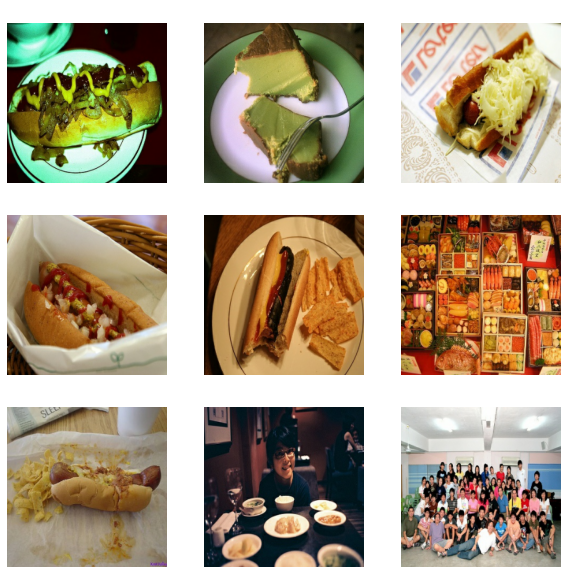

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], c="w")
        plt.axis("off")

In [10]:
test_dataset = image_dataset_from_directory(test_dir,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            )

Found 644 files belonging to 2 classes.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

rescale = preprocessing.Rescaling(1. / 255)

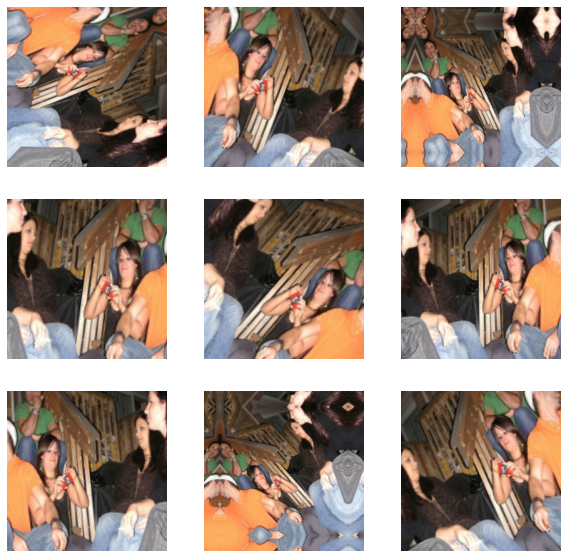

In [13]:
with tf.device('/CPU:0'):
    for image, _ in train_dataset.take(1):
        plt.figure(figsize=(10, 10))
        first_image = image[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
            plt.imshow(augmented_image[0] / 255)
            plt.axis('off')

In [14]:
from IPython.display import clear_output
from matplotlib import pyplot as plt


class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)
            axs[i].legend()
            axs[i].grid()
            axs[i].set_xlabel('epoc')
            axs[i].set_ylim(0)
        plt.tight_layout()
        plt.show()

# Standard AlexNet nodel
(see Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow for details)

AlexNet used three major concepts:
1. Data augmentation — to increase the variance in the data.
2. Dropout — to deal with overfitting.
3. ReLU activation unit — to deal with vanishing gradient problem.

In [15]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = rescale(x)
x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(x)
x = layers.MaxPool2D((3, 3), strides=2)(x)
x = layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPool2D((3, 3), strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((3, 3), strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_alexnet = tf.keras.Model(inputs, outputs, name='AlexNet')

model_alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                           

In [16]:
model_alexnet.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])

In [17]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                  PlotLearning()]

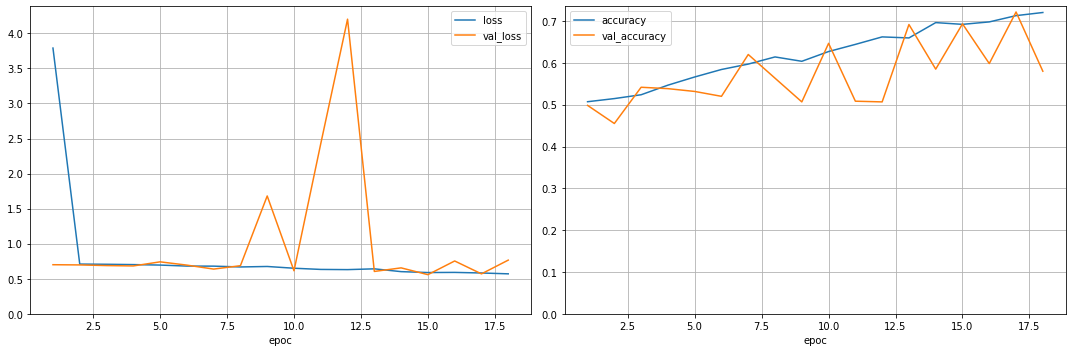

75/75 [==============================] - 10s 129ms/step - loss: 0.5701 - accuracy: 0.7204 - val_loss: 0.7657 - val_accuracy: 0.5800


In [18]:
history_alexnet = model_alexnet.fit(train_dataset,
                                    epochs=20,
                                    validation_data=validation_dataset,
                                    callbacks=callbacks_list)

In [19]:
model_alexnet.evaluate(test_dataset)

21/21 [==============================] - 1s 38ms/step - loss: 0.5630 - accuracy: 0.7127


[0.56304532289505, 0.7127329111099243]

2022-09-01 11:41:13.103020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


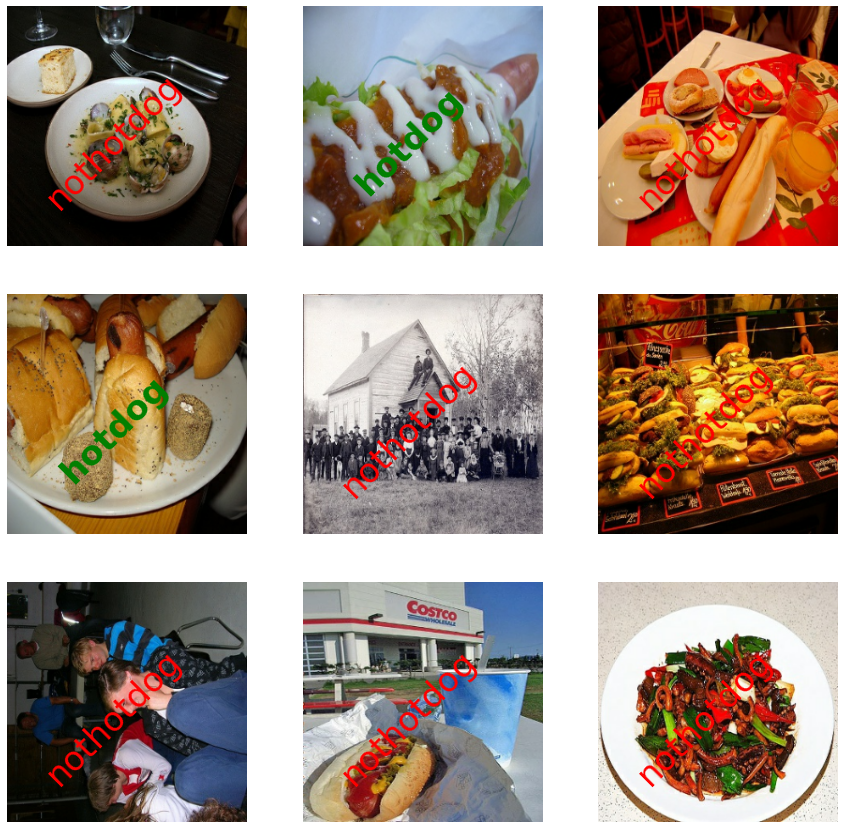

In [20]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_alexnet.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label == 'hotdog':
        plt.text(50, 200, label, rotation=45, color='green', fontsize=34, fontweight='bold')
    else:
        plt.text(35, 215, label, rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")


# Transfer Learning with ResNet V2

In [21]:
base_model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet',
                                                                                             include_top=False,
                                                                                             input_shape=(256, 256, 3))

In [22]:
base_model_inception_resnet_v2.trainable = False

In [23]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model_inception_resnet_v2(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_resnet_v2 = tf.keras.Model(inputs, outputs, name='inception_resnet_v2')

In [24]:
model_inception_resnet_v2.summary()

Model: "inception_resnet_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                               

In [25]:
model_inception_resnet_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                  metrics=['accuracy'])

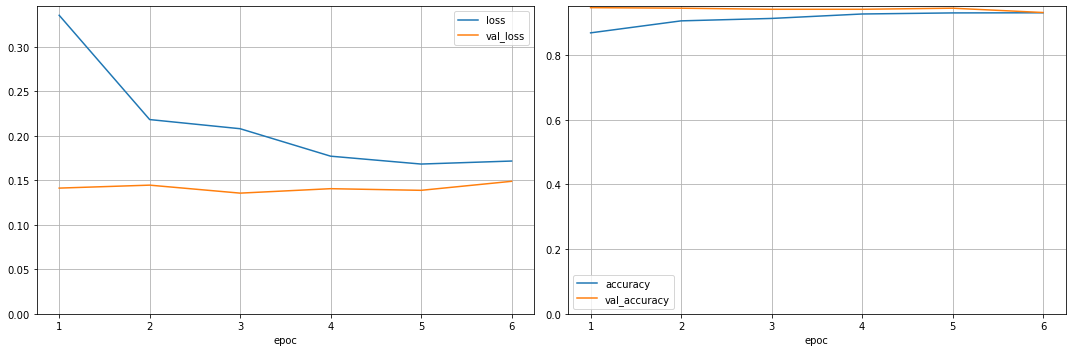

75/75 [==============================] - 21s 280ms/step - loss: 0.1717 - accuracy: 0.9308 - val_loss: 0.1489 - val_accuracy: 0.9317


In [26]:
history_inception_resnet_v2 = model_inception_resnet_v2.fit(train_dataset,
                                                            epochs=10,
                                                            validation_data=validation_dataset,
                                                            callbacks=callbacks_list)

In [27]:
model_inception_resnet_v2.evaluate(test_dataset)

21/21 [==============================] - 5s 247ms/step - loss: 0.0928 - accuracy: 0.9581


[0.0927712619304657, 0.9580745697021484]

2022-09-01 11:43:38.284891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


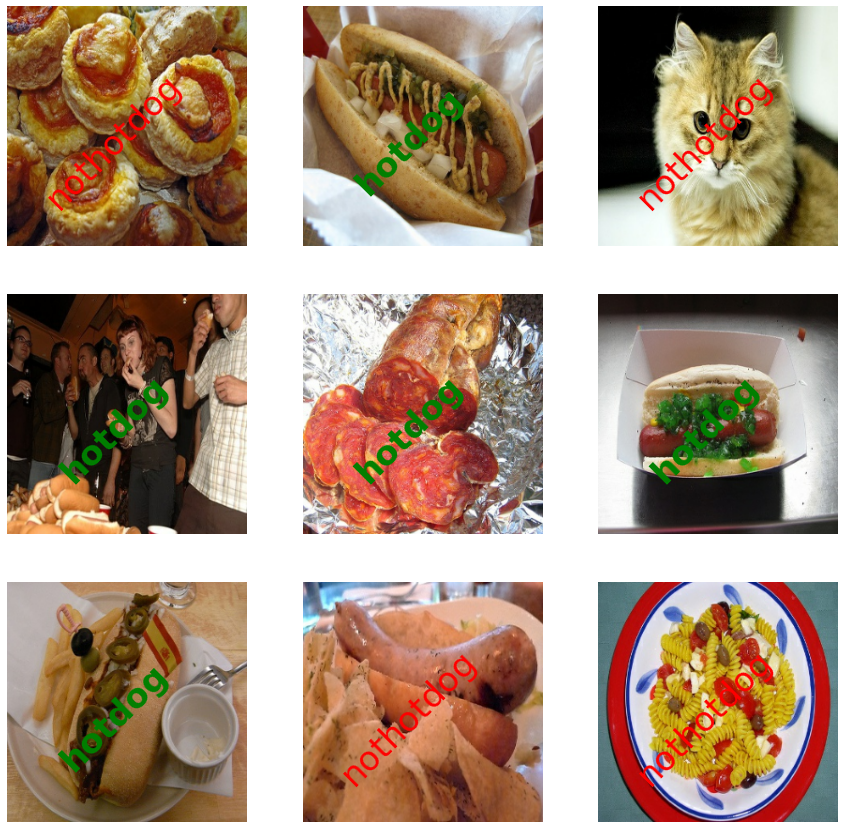

In [28]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_inception_resnet_v2.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label == 'hotdog':
        plt.text(50, 200, label, rotation=45, color='green', fontsize=34, fontweight='bold')
    else:
        plt.text(35, 215, label, rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")


In [29]:
# Test with new picture

In [31]:
import numpy as np

hotdog_url = "https://thumbs.dreamstime.com/b/hot-dog-9295215.jpg"

hotdog_path = tf.keras.utils.get_file('hot-dog', origin=hotdog_url)

img = tf.keras.utils.load_img(
    hotdog_path, target_size=IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_inception_resnet_v2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#plt.imshow(img_array.astype("uint8"))

This image most likely belongs to hotdog with a 100.00 percent confidence.
